### Gender Bias Detection and Fairness Evaluation using Fairlearn on the Cardiovascular Disease Dataset
(Source: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset/data)

In [1]:
#installation
!pip install fairlearn


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\patri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
# import libraries
from fairlearn.metrics import (
    MetricFrame, selection_rate,
    false_positive_rate, false_negative_rate,
    true_positive_rate, true_negative_rate,
    demographic_parity_difference, equalized_odds_difference
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss
)

### Bias detection for KNN

In [3]:
import pandas as pd

# Load KNN results
knn_df = pd.read_csv("CVDKaggleData_75F25M__tunedKNN_predictions.csv")

print(knn_df.head())

   gender  y_true    y_prob  y_pred
0       0       0  0.344828       0
1       0       0  0.862069       1
2       1       0  0.379310       0
3       0       0  0.379310       0
4       0       0  0.275862       0


In [4]:
# Extract common columns
y_true_knn = knn_df["y_true"].values
y_prob_knn = knn_df["y_prob"].values
y_pred_knn = knn_df["y_pred"].values
gender_knn = knn_df["gender"].values

# Use gender_knn as the protected attribute (0/1 as in our CSV)
protected_attr_knn = gender_knn

print("Example rows:\n", knn_df.head())

Example rows:
    gender  y_true    y_prob  y_pred
0       0       0  0.344828       0
1       0       0  0.862069       1
2       1       0  0.379310       0
3       0       0  0.379310       0
4       0       0  0.275862       0


In [5]:
# y_pred_knn already generated
# protected_attr = gender column (0=female, 1=male)

# Demographic Parity Difference
dp_diff_knn = demographic_parity_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

# Equalized Odds Difference
eod_diff_knn = equalized_odds_difference(y_true_knn, y_pred_knn, sensitive_features=protected_attr_knn)

print("DPD and EPD - KNN")
print(f"Demographic Parity Difference: {dp_diff_knn:.4f}")
print(f"Equalized Odds Difference: {eod_diff_knn:.4f}")

DPD and EPD - KNN
Demographic Parity Difference: 0.0458
Equalized Odds Difference: 0.0564


# Interpretation of DPD and EOD – KNN

The KNN model shows a **Demographic Parity Difference (DPD) of 0.0458**.  
This means that the difference in positive prediction rates between genders is about **4.6 percentage points**, indicating that one gender is more likely to receive positive predictions than the other.  

The **Equalized Odds Difference (EOD) is 0.0564**, which reflects a gap of about **5.6 percentage points** in error rates (true positive rate and false positive rate) between genders.  
This suggests that the model’s ability to correctly and incorrectly classify outcomes is not equal across groups.  

**Conclusion:**  
KNN introduces **moderate gender disparities**, both in prediction rates (DPD) and in error rates (EOD).  

----

In [6]:
# MetricFrame for extended analysis - define metrics
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate
import matplotlib.pyplot as plt
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "f1": f1_score, 
    "selection_rate": selection_rate,
    "tpr": true_positive_rate,
    "fpr": false_positive_rate,
    "tnr": true_negative_rate,
    "fnr": false_negative_rate,
}


KNN Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.710948   0.709478  0.715255  0.712355        0.504482   
1                    0.697740   0.707167  0.658842  0.682150        0.458654   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.715255  0.293366  0.706634  0.284745  
1                    0.658842  0.264542  0.735458  0.341158  


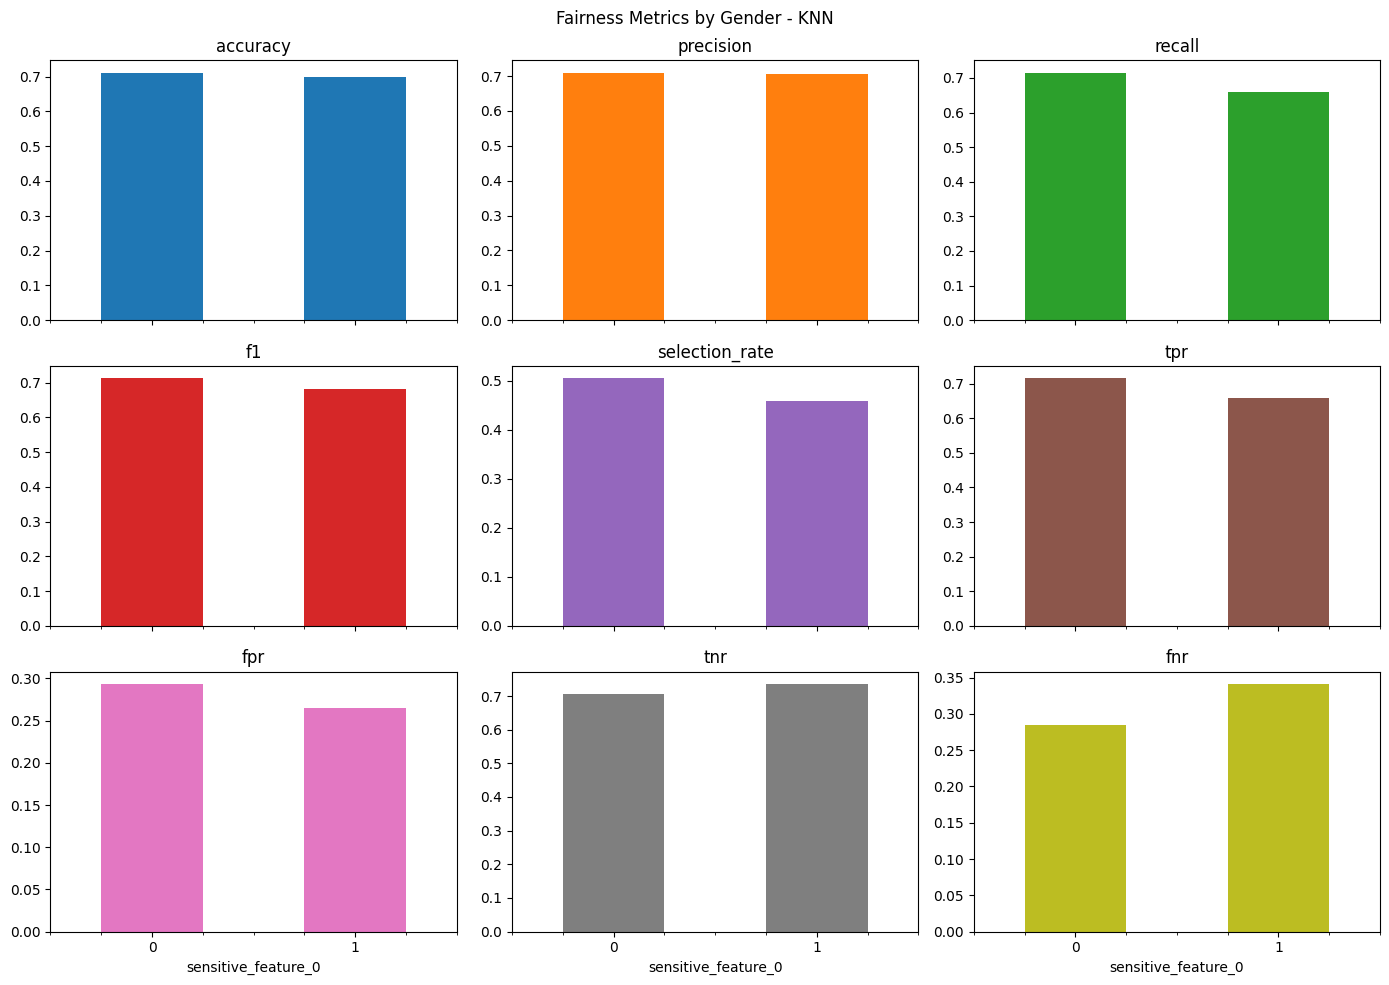


Between-group differences (max group − min group):
accuracy          0.013208
precision         0.002311
recall            0.056413
f1                0.030205
selection_rate    0.045828
tpr               0.056413
fpr               0.028824
tnr               0.028824
fnr               0.056413
dtype: float64

Between-group ratios (min / max):
accuracy          0.981422
precision         0.996743
recall            0.921129
f1                0.957598
selection_rate    0.909158
tpr               0.921129
fpr               0.901748
tnr               0.960808
fnr               0.834642
dtype: float64

Disparate Impact Ratio (selection rate): 0.9092
Equality of Opportunity Difference (TPR gap): 0.0564


In [7]:
# MetricFrame
metric_frame_knn = MetricFrame(
    metrics=metrics,
    y_true=y_true_knn,
    y_pred=y_pred_knn,
    sensitive_features=protected_attr_knn
)

print("\nKNN Fairness Metrics by Gender:")
print(metric_frame_knn.by_group)

metric_frame_knn.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - KNN")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_knn.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_knn.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_knn = metric_frame_knn.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_knn:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_knn = metric_frame_knn.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_knn = metric_frame_knn.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_knn:.4f}")

### Interpretation of KNN Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.711  
  - Male (1): 0.698  
  - → Small gap (~1.3 percentage points), females slightly higher.

- **Precision**
  - Female: 0.709  
  - Male: 0.707  
  - → Nearly identical precision across genders.

- **Recall / True Positive Rate (TPR)**
  - Female: 0.715  
  - Male: 0.659  
  - → Recall is ~5.6 percentage points lower for males → the model **misses more true positives** in the male group.

- **False Positive Rate (FPR)**
  - Female: 0.293  
  - Male: 0.265  
  - → Females experience slightly more false alarms.

- **Selection Rate**
  - Female: 0.504  
  - Male: 0.459  
  - → The model predicts more positives for females (~4.6 percentage point gap).

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0458**  
  - There is a 4.6 percentage point gap in positive prediction rates across genders.  
  - Indicates moderate demographic disparity.  

- **Disparate Impact Ratio (DIR): 0.9092**  
  - Male selection rate is ~91% of the female selection rate.  
  - Below 1 → some disparate impact against males, but still above the 0.8 “80% rule” threshold.  

- **Equality of Opportunity Difference (EOP diff / TPR gap): 0.0564**  
  - Recall is ~5.6 percentage points lower for males.  
  - Suggests men with the condition are more likely to be missed.  

- **Equalized Odds Difference (EOD): 0.0564**  
  - Maximum disparity across TPR and FPR.  
  - Reflects imbalance in how errors are distributed between genders.  

#### Overall interpretation
The **KNN model shows moderate gender disparities**.  
- **Males are disadvantaged** with lower recall and selection rates, meaning they are less likely to be correctly identified as positive.  
- **Females are slightly disadvantaged** with a higher false positive rate.  
While accuracy and precision are balanced, the **recall gap** is the most critical fairness concern, as it directly impacts whether cases in the male group are correctly detected.

---

In [8]:
y_score_knn = knn_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_knn
def roc_auc_safe(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_knn = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN - ROC-AUC by group:")
print(auc_mf_knn.by_group)

brier_mf_knn = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_knn,
    y_pred=y_prob_knn,                     
    sensitive_features=protected_attr_knn
)
print("\nKNN- Brier score by group (lower is better):")
print(brier_mf_knn.by_group)


KNN - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.766127
1                    0.751496

KNN- Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.196888
1                    0.202962


### KNN – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- Female (0): **0.7661**  
- Male (1): **0.7515**  

**Interpretation:**  
ROC-AUC reflects the model’s ability to distinguish between positive and negative cases.  
Here, females score slightly higher (+0.015), but both values are close.  
This means the KNN model discriminates outcomes **almost equally well** across genders, with only a minor advantage for females.  
Absolute values (~0.75–0.77) indicate **good discriminative power** overall.  

---

#### Brier score by group (lower = better)
- Female (0): **0.1969**  
- Male (1): **0.2030**  

**Interpretation:**  
The Brier score measures calibration — how close predicted probabilities are to actual outcomes.  
Scores are very similar, with males showing a slightly worse calibration (+0.006).  
Both groups are well-calibrated, with values below 0.21, which is considered **strong reliability** for probabilistic predictions.  

---

### Overall
From a **fairness perspective**, KNN shows **balanced probabilistic performance across genders**.  
- Discrimination (ROC-AUC) is strong and nearly equal, with a minor female advantage.  
- Calibration (Brier score) is also close, though slightly less favorable for males.  

The model’s probability estimates can be considered **trustworthy and equitable** for both genders, with no substantial fairness concerns in probabilistic terms.  

---

### Bias detection for the Decision Tree Model

In [9]:
# Load DT results
dt_df = pd.read_csv("CVDKaggleData_75F25M_DT_tuned_predictions.csv")
print(dt_df.head())

   gender  y_true  y_pred_dt    y_prob
0       0       0          0  0.256610
1       0       0          1  0.842593
2       1       0          0  0.417021
3       0       0          0  0.335329
4       0       0          0  0.354173


In [10]:
import re

# Extract common columns
y_true_dt = dt_df["y_true"].values
y_prob_dt = dt_df["y_prob"].values
y_pred_dt = dt_df["y_pred_dt"].values
gender_dt = dt_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_dt = gender_dt


print("Example rows:\n", dt_df.head())

Example rows:
    gender  y_true  y_pred_dt    y_prob
0       0       0          0  0.256610
1       0       0          1  0.842593
2       1       0          0  0.417021
3       0       0          0  0.335329
4       0       0          0  0.354173


In [11]:
# Demographic Parity Difference
dp_diff_dt = demographic_parity_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

# Equalized Odds Difference
eod_diff_dt = equalized_odds_difference(y_true_dt, y_pred_dt, sensitive_features=protected_attr_dt)

print("DPD and EOD - DT")
print(f"Demographic Parity Difference: {dp_diff_dt:.4f}")
print(f"Equalized Odds Difference: {eod_diff_dt:.4f}")

DPD and EOD - DT
Demographic Parity Difference: 0.0038
Equalized Odds Difference: 0.0078


### DT – Group Fairness Metrics

- **Demographic Parity Difference (DPD): 0.0038**  
  The difference in positive prediction rates between genders is only **0.38 percentage points**.  
  → This indicates that the DT model predicts positive outcomes at **almost identical rates** for males and females.

- **Equalized Odds Difference (EOD): 0.0078**  
  The largest gap in error rates (TPR/FPR) across genders is less than **0.8 percentage points**.  
  → This means the model’s ability to correctly identify positives and avoid false positives is **highly consistent** across genders.

---

### Overall Interpretation
The DT model shows **very strong fairness performance**. Both positive prediction rates and error distributions are nearly identical for males and females.  
→ **No meaningful gender disparity is present** according to DPD and EOD.  

---


DT Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.711084   0.712763  0.707926  0.710336        0.497012   
1                    0.711608   0.703590  0.715702  0.709594        0.500770   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.707926  0.285753  0.714247  0.292074  
1                    0.715702  0.292362  0.707638  0.284298  


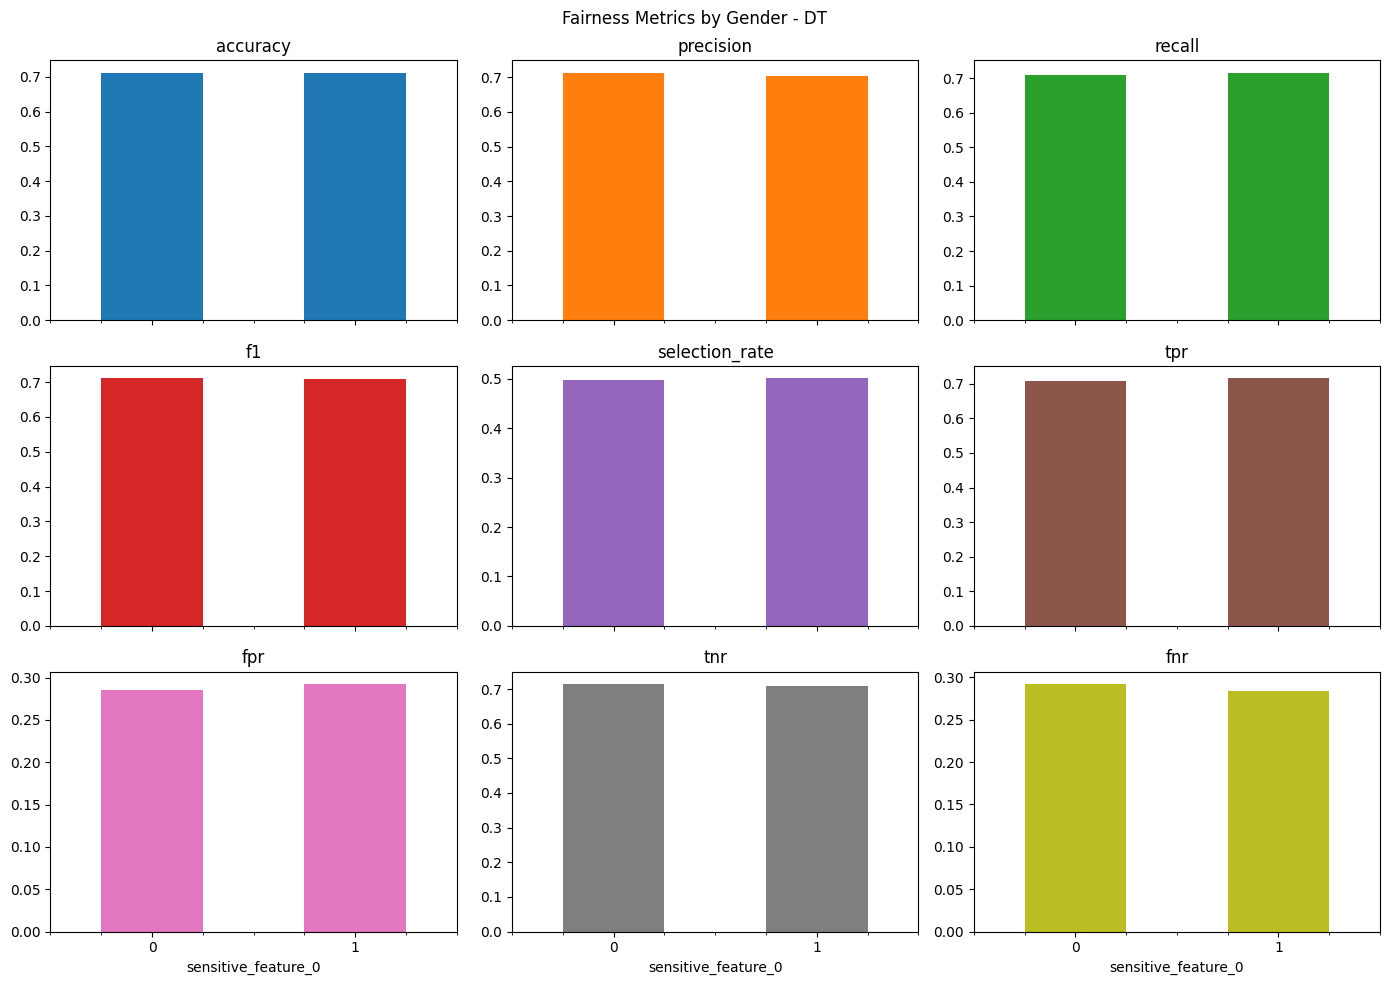


Between-group differences (max group − min group):
accuracy          0.000524
precision         0.009173
recall            0.007775
f1                0.000742
selection_rate    0.003759
tpr               0.007775
fpr               0.006609
tnr               0.006609
fnr               0.007775
dtype: float64

Between-group ratios (min / max):
accuracy          0.999264
precision         0.987130
recall            0.989136
f1                0.998955
selection_rate    0.992494
tpr               0.989136
fpr               0.977394
tnr               0.990747
fnr               0.973378
dtype: float64

Disparate Impact Ratio (selection rate): 0.9925
Equality of Opportunity Difference (TPR gap): 0.0078


In [12]:
# MetricFrame
metric_frame_dt = MetricFrame(
    metrics=metrics,
    y_true=y_true_dt,
    y_pred=y_pred_dt,
    sensitive_features=protected_attr_dt
)

print("\nDT Fairness Metrics by Gender:")
print(metric_frame_dt.by_group)

metric_frame_dt.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - DT")
plt.tight_layout()
plt.show()

# Group summaries (use the right variable name)
print("\nBetween-group differences (max group − min group):")
print(metric_frame_dt.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_dt.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_dt = metric_frame_dt.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_dt:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_dt = metric_frame_dt.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_dt = metric_frame_dt.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_dt:.4f}")

### Interpretation of DT Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.711  
  - Male (1): 0.712  
  - → Nearly identical accuracy across genders (gap ≈ 0.0005).

- **Precision**
  - Female: 0.713  
  - Male: 0.704  
  - → Slightly higher precision for females (~0.9 percentage points).  
    Males are marginally more prone to false positives.

- **Recall / True Positive Rate (TPR)**
  - Female: 0.708  
  - Male: 0.716  
  - → Recall is ~0.8 percentage points higher for males, meaning they are slightly less likely to be missed.

- **False Positive Rate (FPR)**
  - Female: 0.286  
  - Male: 0.292  
  - → Males receive slightly more false positives, but the gap is very small (~0.7 percentage points).

- **Selection Rate**
  - Female: 0.497  
  - Male: 0.501  
  - → Positive predictions are almost perfectly balanced between genders.

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0038**  
  Positive prediction rates differ by less than 0.4 percentage points → almost no demographic disparity.

- **Disparate Impact Ratio (DIR): 0.9925**  
  Male selection rate is ~99.3% of the female rate → very close to parity.

- **Equality of Opportunity Difference (TPR gap): 0.0078**  
  Recall difference across genders is <1 percentage point → indicates highly balanced opportunity.

- **Equalized Odds Difference (EOD): 0.0078**  
  Maximum difference in TPR/FPR is <1 percentage point → error rates distributed almost equally.

#### Overall interpretation
The **Decision Tree model is highly fair across genders**. Differences in accuracy, recall, precision, and selection rates are negligible, with all disparities well under 1%.  
→ Both males and females are treated almost identically in terms of positive predictions and error rates.  

---

In [13]:
import numpy as np

y_score_dt = dt_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_dt, y_score_dt=y_score_dt):
    try:
        return roc_auc_score(y_true, y_score_dt)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_dt = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - ROC-AUC by group:")
print(auc_mf_dt.by_group)

brier_mf_dt = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_dt,
    y_pred=y_prob_dt,                     
    sensitive_features=protected_attr_dt
)
print("\nDT - Brier score by group (lower is better):")
print(brier_mf_dt.by_group)


DT - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.770874
1                    0.755612

DT - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.193990
1                    0.200057


### Interpretation of DT – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- **Female (0): 0.771**  
- **Male (1): 0.756**  

→ ROC-AUC values are high, showing good discriminative ability overall.  
The model separates positives and negatives slightly **better for females** (~1.5 percentage point advantage).

#### Brier score by group (↓ lower is better)
- **Female (0): 0.194**  
- **Male (1): 0.200**  

→ Predicted probabilities are well calibrated for both groups.  
Calibration is **slightly better for females**, with a smaller Brier score gap (~0.006).

#### Interpretation
The Decision Tree model shows **strong and fairly balanced probabilistic performance**.  
- Females enjoy a small advantage in both discrimination (higher ROC-AUC) and calibration (lower Brier score).  
- The differences are minor, suggesting the model’s probability outputs are **reliable and consistent across genders**.

---

### Bias detection for the Random Forest Model

In [14]:
rf_df = pd.read_csv("CVDKaggleData_75F25M_RF_tuned_predictions.csv")
print(rf_df.head())

   gender  y_true  y_pred_rf    y_prob
0       0       0          0  0.284528
1       0       0          1  0.804516
2       1       0          0  0.347408
3       0       0          0  0.272444
4       0       0          1  0.537651


In [15]:
# Extract common columns
y_true_rf = rf_df["y_true"].values
y_pred_rf = rf_df["y_pred_rf"].values
y_prob_rf = rf_df["y_prob"].values
gender_rf = rf_df["gender"].values


# Use gender_knn as the protected attribute (0/1 as in your CSV)
protected_attr_rf = gender_rf


print("Example rows:\n", rf_df.head())

Example rows:
    gender  y_true  y_pred_rf    y_prob
0       0       0          0  0.284528
1       0       0          1  0.804516
2       1       0          0  0.347408
3       0       0          0  0.272444
4       0       0          1  0.537651


In [16]:
# Demographic Parity Difference
dp_diff_rf = demographic_parity_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

# Equalized Odds Difference
eod_diff_rf = equalized_odds_difference(y_true_rf, y_pred_rf, sensitive_features=protected_attr_rf)

print("DPD and EOD - RF")
print(f"Demographic Parity Difference: {dp_diff_rf:.4f}")
print(f"Equalized Odds Difference: {eod_diff_rf:.4f}")

DPD and EOD - RF
Demographic Parity Difference: 0.0096
Equalized Odds Difference: 0.0228


### Interpretation of RF – Group Fairness Metrics

- **Demographic Parity Difference (DPD): 0.0096**  
  → The positive prediction rates between genders differ by less than 1%.  
  This indicates **very minor disparity** in how often each gender is classified as positive.

- **Equalized Odds Difference (EOD): 0.0228**  
  → The maximum difference across error rates (True Positive Rate and False Positive Rate) is about 2.3 percentage points.  
  This shows a **small imbalance in error distribution** between genders, but the gap remains low.

#### Interpretation:
The Random Forest model demonstrates **fair behavior across genders**, with nearly identical selection rates and only slight differences in error rates. From a fairness perspective, the disparities are minimal and unlikely to reflect strong bias.

---


Random Forest Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.710812   0.729690  0.670467  0.698826        0.459794   
1                    0.701335   0.706236  0.673448  0.689453        0.469440   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.670467  0.248777  0.751223  0.329533  
1                    0.673448  0.271624  0.728376  0.326552  


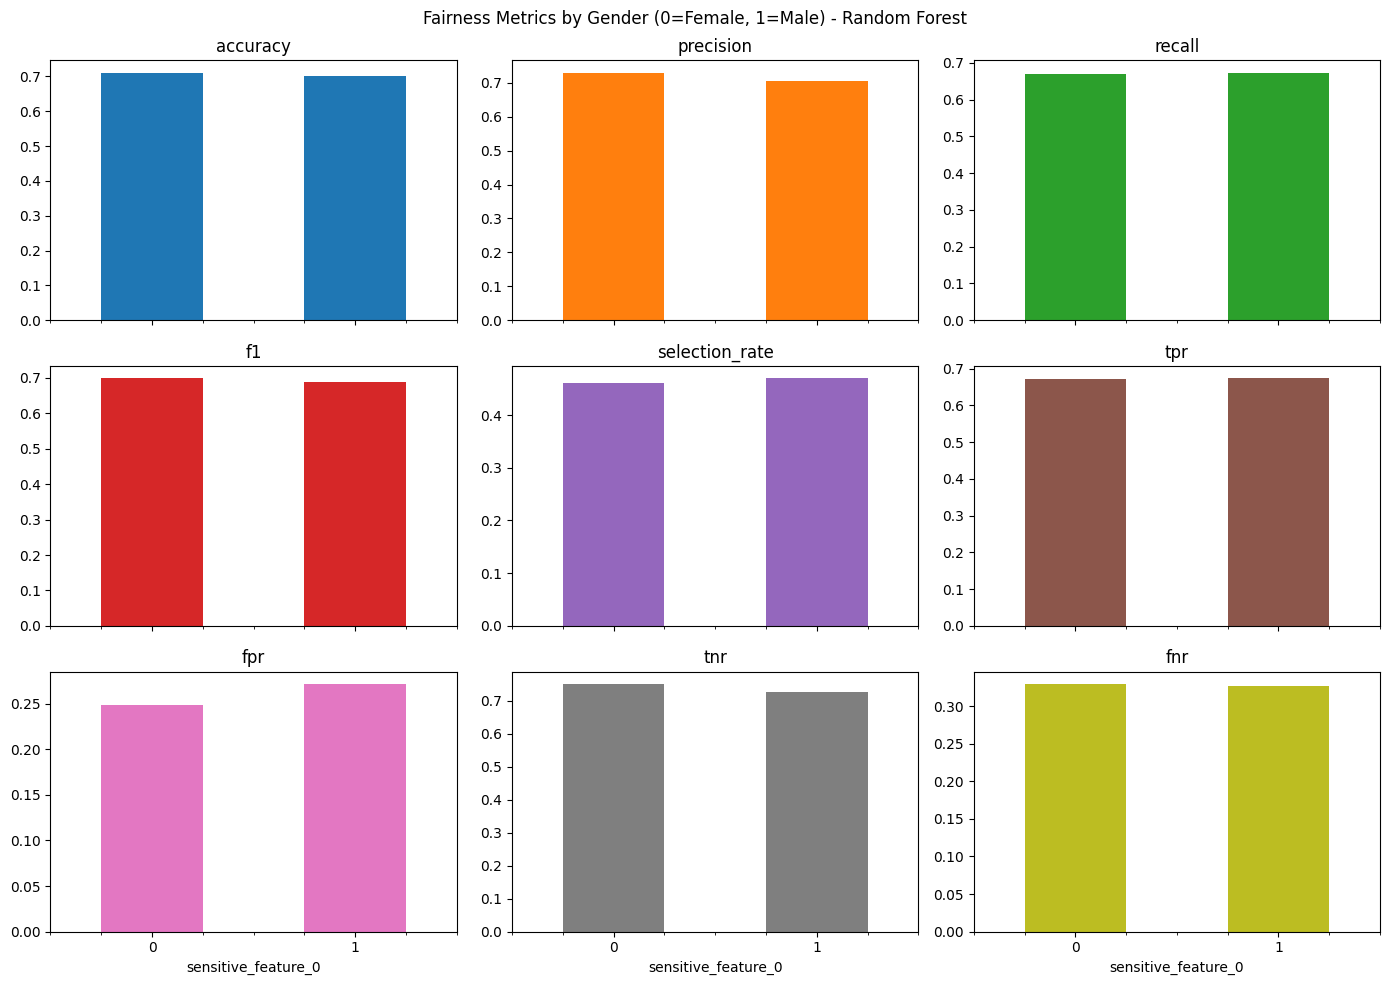


Between-group differences (max group − min group):
accuracy          0.009477
precision         0.023453
recall            0.002981
f1                0.009373
selection_rate    0.009647
tpr               0.002981
fpr               0.022847
tnr               0.022847
fnr               0.002981
dtype: float64

Between-group ratios (min / max):
accuracy          0.986668
precision         0.967858
recall            0.995573
f1                0.986587
selection_rate    0.979451
tpr               0.995573
fpr               0.915887
tnr               0.969587
fnr               0.990953
dtype: float64

Disparate Impact Ratio (selection rate): 0.9795
Equality of Opportunity Difference (TPR gap): 0.0030


In [17]:
#MetricFrame for extended analysis
metric_frame_rf = MetricFrame(
    metrics=metrics,
    y_true=y_true_rf,
    y_pred=y_pred_rf,
    sensitive_features=protected_attr_rf
)

print("\nRandom Forest Fairness Metrics by Gender:")
print(metric_frame_rf.by_group)

metric_frame_rf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(14, 10),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender (0=Female, 1=Male) - Random Forest")
plt.tight_layout()
plt.show()

# Group summaries 
print("\nBetween-group differences (max group − min group):")
print(metric_frame_rf.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_rf.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_rf = metric_frame_rf.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_rf:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_rf = metric_frame_rf.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_rf = metric_frame_rf.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_rf:.4f}")

### Interpretation of Random Forest Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.711  
  - Male (1): 0.701  
  - → Very small difference (~0.009), accuracy is balanced across genders.

- **Precision**
  - Female: 0.730  
  - Male: 0.706  
  - → Precision is ~2.3 percentage points higher for females, meaning males experience slightly more false positives.

- **Recall / True Positive Rate (TPR)**
  - Female: 0.670  
  - Male: 0.673  
  - → Nearly identical recall across genders (gap ≈ 0.003). Both groups have equal chance of being correctly identified.

- **False Positive Rate (FPR)**
  - Female: 0.249  
  - Male: 0.272  
  - → Males face a slightly higher false alarm rate (~2.3% gap).

- **Selection Rate**
  - Female: 0.460  
  - Male: 0.469  
  - → Prediction of positives is nearly balanced; males are slightly more likely to be predicted positive (~1% higher).

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0096**  
  - Very small disparity in positive prediction rates across genders.  

- **Disparate Impact Ratio (DIR): 0.9795**  
  - Male selection rate is ~98% of female selection rate.  
  - Well above the 0.8 threshold, indicating fairness is maintained.  

- **Equality of Opportunity Difference (TPR gap): 0.0030**  
  - Recall difference is negligible (<0.3%).  
  - Suggests the model identifies positives almost equally well for both genders.  

- **Equalized Odds Difference (EOD): 0.0228**  
  - Error rate disparities are small but mostly driven by a slightly higher FPR for males.

#### Interpretation
The Random Forest model shows **very balanced performance across genders**.  
- Females benefit from slightly higher precision (fewer false positives).  
- Males experience a marginally higher false positive rate but a nearly equal recall.  
- Overall disparities are very small, indicating that the model can be considered **fair and reliable across genders**.

---

In [18]:
import numpy as np

y_score_rf = rf_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_dt
def roc_auc_safe(y_true=y_true_rf, y_score_rf=y_score_rf):
    try:
        return roc_auc_score(y_true, y_score_rf)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_rf = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF -ROC-AUC by group:")
print(auc_mf_rf.by_group)

brier_mf_rf = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_rf,
    y_pred=y_prob_rf,                     
    sensitive_features=protected_attr_rf
)
print("\nRF - Brier score by group (lower is better):")
print(brier_mf_rf.by_group)


RF -ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.769735
1                    0.756634

RF - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.195018
1                    0.201354


### Random Forest – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- **Female (0): 0.770**  
- **Male (1): 0.757**  

**Interpretation:**  
The model’s ability to distinguish between positive and negative cases is slightly higher for females (~1.3 percentage points). Both groups have good discriminative performance (AUC > 0.75), but the model is marginally more effective for females.

---

#### Brier score by group (lower = better)
- **Female (0): 0.195**  
- **Male (1): 0.201**  

**Interpretation:**  
The Brier score indicates how well the predicted probabilities are calibrated. Both groups have low scores, showing good probability reliability. However, probabilities are slightly better calibrated for females (gap ≈ 0.006).

---

### Overall interpretation
The Random Forest model demonstrates **good probabilistic fairness**. While performance is strong for both genders, it shows a **small advantage for females**, both in discrimination (ROC-AUC) and calibration (Brier score). The differences are minor, so the model can be considered balanced overall.

---

### Bias detection for MLP

In [19]:
mlp_df = pd.read_csv("CVDKaggleData_75F25M_MLP_adamtuned_predictions.csv")
print(mlp_df.head())

   gender  y_true  y_pred    y_prob
0       0       0       0  0.332016
1       0       0       1  0.861841
2       1       0       0  0.411947
3       0       0       0  0.338920
4       0       0       0  0.319818


In [20]:
# Extract common columns 
y_true_mlp = mlp_df["y_true"].values 
y_prob_mlp = mlp_df["y_prob"].values
y_pred_mlp = mlp_df["y_pred"].values
gender_mlp = mlp_df["gender"].values 

# Use gender_mlp as the protected attribute
protected_attr_mlp = gender_mlp 


print("Example rows:\n", mlp_df.head())

Example rows:
    gender  y_true  y_pred    y_prob
0       0       0       0  0.332016
1       0       0       1  0.861841
2       1       0       0  0.411947
3       0       0       0  0.338920
4       0       0       0  0.319818


In [21]:
# Demographic Parity Difference
dp_diff_mlp = demographic_parity_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

# Equalized Odds Difference
eod_diff_mlp = equalized_odds_difference(y_true_mlp, y_pred_mlp, sensitive_features=protected_attr_mlp)

print("DPD and EPD - MLP")
print(f"Demographic Parity Difference (MLP): {dp_diff_mlp:.4f}")
print(f"Equalized Odds Difference (MLP): {eod_diff_mlp:.4f}")

DPD and EPD - MLP
Demographic Parity Difference (MLP): 0.0289
Equalized Odds Difference (MLP): 0.0421


### Interpretation of MLP Fairness Metrics

#### Demographic Parity Difference (DPD): **0.0289**
- The positive prediction rates differ by ~2.9 percentage points between genders.  
- This indicates a **small disparity** in how often each gender is predicted as positive.  

#### Equalized Odds Difference (EOD): **0.0421**
- The maximum gap in error rates (True Positive Rate and False Positive Rate) between genders is ~4.2 percentage points.  
- This suggests a **slight imbalance** in how errors are distributed across genders.  

---

### Overall interpretation
The MLP model shows **minor fairness disparities**.  
- Gender groups receive predictions at slightly different rates (DPD).  
- Error distribution (EOD) also differs modestly.  

These gaps are relatively small, meaning the model is **reasonably fair**, though not entirely gender-neutral.

---


MLP Fairness Metrics by Gender:
                     accuracy  precision    recall        f1  selection_rate  \
sensitive_feature_0                                                            
0                    0.714208   0.725071  0.690825  0.707534        0.476773   
1                    0.704160   0.694261  0.713093  0.703551        0.505650   

                          tpr       fpr       tnr       fnr  
sensitive_feature_0                                          
0                    0.690825  0.262371  0.737629  0.309175  
1                    0.713093  0.304502  0.695498  0.286907  


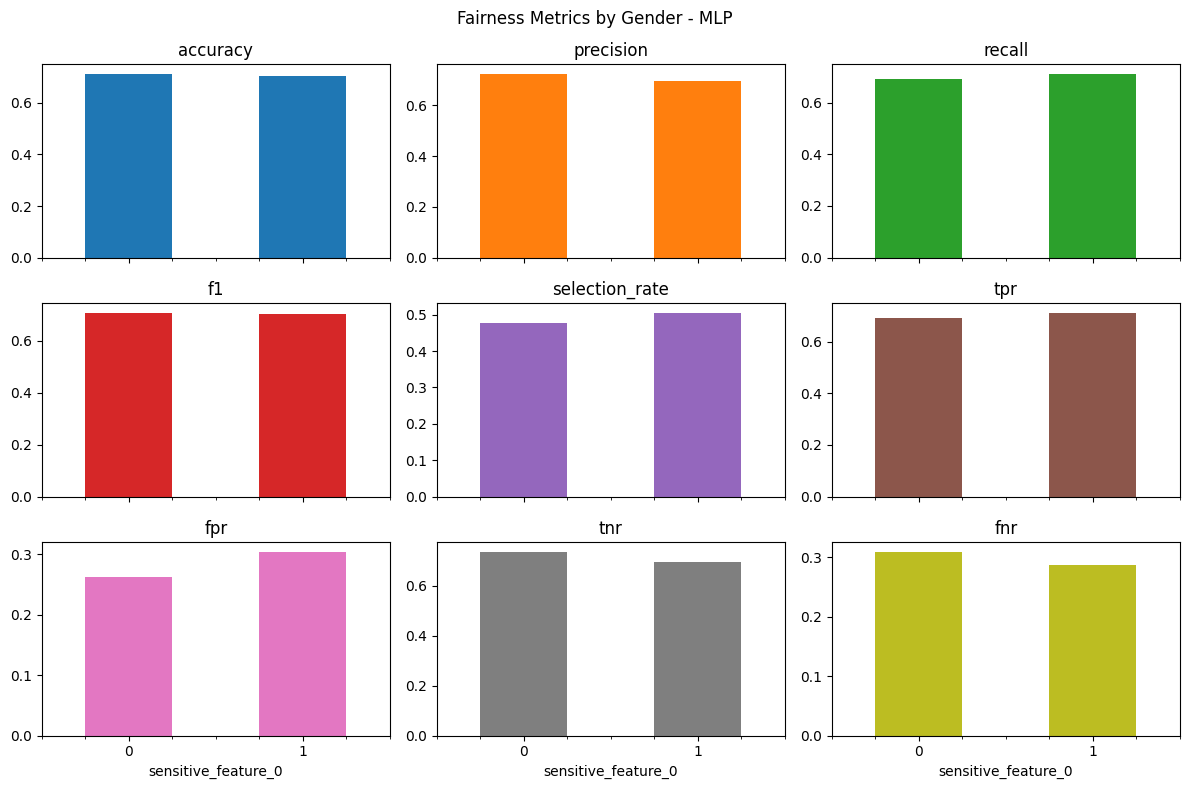


Between-group differences (max group − min group):
accuracy          0.010048
precision         0.030810
recall            0.022268
f1                0.003983
selection_rate    0.028877
tpr               0.022268
fpr               0.042131
tnr               0.042131
fnr               0.022268
dtype: float64

Between-group ratios (min / max):
accuracy          0.985931
precision         0.957507
recall            0.968772
f1                0.994371
selection_rate    0.942891
tpr               0.968772
fpr               0.861640
tnr               0.942883
fnr               0.927975
dtype: float64

Disparate Impact Ratio (selection rate): 0.9429
Equality of Opportunity Difference (TPR gap): 0.0223


In [22]:
#Create MetricFrame for the MLP model
metric_frame_mlp = MetricFrame(
    metrics=metrics,
    y_true=y_true_mlp,
    y_pred=y_pred_mlp,
    sensitive_features=protected_attr_mlp
)

print("\nMLP Fairness Metrics by Gender:")
print(metric_frame_mlp.by_group)

#visualization
metric_frame_mlp.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    figsize=(12, 8),
    legend=False,
    rot=0
)
plt.suptitle("Fairness Metrics by Gender - MLP")
plt.tight_layout()
plt.show()

# Group summaries
print("\nBetween-group differences (max group − min group):")
print(metric_frame_mlp.difference())

print("\nBetween-group ratios (min / max):")
print(metric_frame_mlp.ratio())

# Disparate Impact Ratio (selection_rate ratio)
dir_value_mlp = metric_frame_mlp.ratio()["selection_rate"]
print(f"\nDisparate Impact Ratio (selection rate): {dir_value_mlp:.4f}")

# Demographic Parity Ratio (aka Disparate Impact Ratio)
dp_ratio_mlp = metric_frame_mlp.ratio()["selection_rate"]

#Equality of Opportunity (difference in TPR between groups)
eop_diff_mlp = metric_frame_mlp.difference()["tpr"]
print(f"Equality of Opportunity Difference (TPR gap): {eop_diff_mlp:.4f}")

### Interpretation of MLP Fairness Metrics by Gender

#### Group-level performance
- **Accuracy**
  - Female (0): 0.714  
  - Male (1): 0.704  
  - → Slightly higher for females (~1% difference).  

- **Precision**
  - Female: 0.725  
  - Male: 0.694  
  - → Females benefit from higher precision (~3.1% gap), meaning males are more prone to false positives.  

- **Recall / True Positive Rate (TPR)**
  - Female: 0.691  
  - Male: 0.713  
  - → Recall is ~2.2 percentage points higher for males, indicating females are missed slightly more often.  

- **False Positive Rate (FPR)**
  - Female: 0.262  
  - Male: 0.305  
  - → Males experience more false positives (4.2% higher).  

- **Selection Rate**
  - Female: 0.477  
  - Male: 0.506  
  - → The model predicts positives for males more often (~2.9% higher).  

#### Summary metrics
- **Demographic Parity Difference (DPD): 0.0289**  
  - Positive prediction rates differ by ~2.9% between genders.  

- **Disparate Impact Ratio (DIR): 0.9429**  
  - Female selection rate is ~94.3% of the male rate.  
  - Slight disparate impact against females, but still well above the 0.8 “80% rule” threshold.  

- **Equality of Opportunity Difference (EOP diff / TPR gap): 0.0223**  
  - True positive rates differ by ~2.2 percentage points.  
  - Suggests females are slightly more likely to be missed.  

- **Equalized Odds Difference (EOD): 0.0421**  
  - The largest disparity across TPR and FPR is ~4.2%.  
  - Indicates some imbalance in error distribution across genders.  

---

### Overall interpretation
The **MLP model is reasonably fair**, with modest disparities.  
- **Males** are slightly disadvantaged by a higher false positive rate.  
- **Females** are slightly disadvantaged by lower recall and selection rates.  

While no group is severely disadvantaged, the **main fairness concern** is the higher FPR for males, paired with slightly lower recall for females. These differences are relatively small but worth monitoring in fairness-sensitive applications.  

---

In [23]:
import numpy as np

y_score_mlp = mlp_df["y_prob"].values   

#Probabilistic metrics by group using y_prob_mlp
def roc_auc_safe(y_true=y_true_mlp, y_score_mlp=y_score_mlp):
    try:
        return roc_auc_score(y_true, y_score_mlp)
    except ValueError:
        # Happens if a group has only one class in y_true
        return np.nan

auc_mf_mlp = MetricFrame(
    metrics={"roc_auc": roc_auc_safe},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - ROC-AUC by group:")
print(auc_mf_mlp.by_group)

brier_mf_mlp = MetricFrame(
    metrics={"brier": brier_score_loss},
    y_true=y_true_mlp,
    y_pred=y_prob_mlp,                     
    sensitive_features=protected_attr_mlp
)
print("\nMLP - Brier score by group (lower is better):")
print(brier_mf_mlp.by_group)


MLP - ROC-AUC by group:
                      roc_auc
sensitive_feature_0          
0                    0.772530
1                    0.759236

MLP - Brier score by group (lower is better):
                        brier
sensitive_feature_0          
0                    0.193628
1                    0.200184


### MLP – Probabilistic Fairness Metrics by Gender

#### ROC-AUC by group
- Female (0): **0.773**  
- Male (1): **0.759**  

**Interpretation:**  
The AUC values are high, indicating strong discriminative ability. Females have a slightly higher AUC (+0.014), meaning the model separates positive vs. negative cases marginally better for women than for men.  

---

#### Brier score by group (lower = better)
- Female (0): **0.194**  
- Male (1): **0.200**  

**Interpretation:**  
The Brier scores are low, reflecting good probability calibration overall. Females again have a small advantage (lower score by 0.006), suggesting the model’s predicted probabilities are slightly more reliable for women.  

---

### Overall interpretation
The MLP demonstrates **good and balanced probabilistic fairness**. Both genders receive accurate probability estimates, with only minor disparities. Performance is slightly better for females in both discrimination (AUC) and calibration (Brier score), but the differences are small and unlikely to indicate meaningful bias.  

---

## Comparison of Results

In [24]:
# Build results dict
fairlearn_results = {
    "KNN": {
        "Demographic Parity Difference": dp_diff_knn,
        "Equalized Odds Difference": eod_diff_knn,
        "Demographic Parity Ratio": metric_frame_knn.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_knn.difference()["tpr"],
        "MetricFrame": metric_frame_knn.by_group,
        "ROC-AUC by group": auc_mf_knn.by_group,
        "Brier by group": brier_mf_knn.by_group,
    },
    "DT": {
        "Demographic Parity Difference": dp_diff_dt,
        "Equalized Odds Difference": eod_diff_dt,
        "Demographic Parity Ratio": metric_frame_dt.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_dt.difference()["tpr"],
        "MetricFrame": metric_frame_dt.by_group,
        "ROC-AUC by group": auc_mf_dt.by_group,
        "Brier by group": brier_mf_dt.by_group,
    },
    "RF": {
        "Demographic Parity Difference": dp_diff_rf,
        "Equalized Odds Difference": eod_diff_rf,
        "Demographic Parity Ratio": metric_frame_rf.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_rf.difference()["tpr"],
        "MetricFrame": metric_frame_rf.by_group,
        "ROC-AUC by group": auc_mf_rf.by_group,
        "Brier by group": brier_mf_rf.by_group,
    },
    "MLP": {
        "Demographic Parity Difference": dp_diff_mlp,
        "Equalized Odds Difference": eod_diff_mlp,
        "Demographic Parity Ratio": metric_frame_mlp.ratio()["selection_rate"],
        "Equality of Opportunity Difference": metric_frame_mlp.difference()["tpr"],
        "MetricFrame": metric_frame_mlp.by_group,
        "ROC-AUC by group": auc_mf_mlp.by_group,
        "Brier by group": brier_mf_mlp.by_group,
    },
}

# Save the whole thing 
import pickle
with open("Mendeley_75M25F_fairlearn_results.pkl", "wb") as f:
    pickle.dump(fairlearn_results, f)

In [25]:
# Summary table across models
summary_table = pd.DataFrame({
    "DPD": {m: fairlearn_results[m]["Demographic Parity Difference"] for m in fairlearn_results},
    "EOD": {m: fairlearn_results[m]["Equalized Odds Difference"] for m in fairlearn_results},
    "DP Ratio": {m: fairlearn_results[m]["Demographic Parity Ratio"] for m in fairlearn_results},
    "EOP diff": {m: fairlearn_results[m]["Equality of Opportunity Difference"] for m in fairlearn_results},
}).round(4)

# By-group performance table
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

by_group_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

In [26]:
import pandas as pd

# Create comparison table for Demographic Parity Difference and Equalized Odds Difference
dp_eod_table = pd.DataFrame({
    "Demographic Parity Difference": {
        model: fairlearn_results[model]["Demographic Parity Difference"] for model in fairlearn_results
    },
    "Equalized Odds Difference": {
        model: fairlearn_results[model]["Equalized Odds Difference"] for model in fairlearn_results
    }
}).round(4)

# Create comparison table for MetricFrame by_group values across all models
frames = []
for model in fairlearn_results:
    mf = fairlearn_results[model]["MetricFrame"]
    for gender in mf.index:
        row = mf.loc[gender].copy()
        row["Model"] = model
        row["Gender"] = gender
        frames.append(row)

metricframe_table = pd.DataFrame(frames).set_index(["Model", "Gender"]).round(4)

# Display 
display(dp_eod_table)
display(metricframe_table)

,Demographic Parity Difference,Equalized Odds Difference
KNN,0.0458,0.0564
DT,0.0038,0.0078
RF,0.0096,0.0228
MLP,0.0289,0.0421


accuracy  precision  recall      f1  selection_rate     tpr  \
Model Gender                                                                
KNN   0         0.7109     0.7095  0.7153  0.7124          0.5045  0.7153   
      1         0.6977     0.7072  0.6588  0.6821          0.4587  0.6588   
DT    0         0.7111     0.7128  0.7079  0.7103          0.4970  0.7079   
      1         0.7116     0.7036  0.7157  0.7096          0.5008  0.7157   
RF    0         0.7108     0.7297  0.6705  0.6988          0.4598  0.6705   
      1         0.7013     0.7062  0.6734  0.6895          0.4694  0.6734   
MLP   0         0.7142     0.7251  0.6908  0.7075          0.4768  0.6908   
      1         0.7042     0.6943  0.7131  0.7036          0.5056  0.7131   

                 fpr     tnr     fnr  
Model Gender                          
KNN   0       0.2934  0.7066  0.2847  
      1       0.2645  0.7355  0.3412  
DT    0       0.2858  0.7142  0.2921  
      1       0.2924  0.7076  0.2843  
RF    0       0.2488  0.7512  0.3295  
      1       0.2716  0.7284  0.3266  
MLP   0       0.2624  0.7376  0.3092  
      1       0.3045  0.6955  0.2869

# Interpretation of Fairness Metrics (KNN, DT, RF, MLP)

---

### 1. Group Fairness Metrics (DPD & EOD)

- **KNN**  
  - DPD: **0.0458**, EOD: **0.0564**  
  - Largest disparities. Females have higher selection rates and recall; males are more often missed.

- **DT**  
  - DPD: **0.0038**, EOD: **0.0078**  
  - Almost perfectly balanced across genders. Very little disparity.

- **RF**  
  - DPD: **0.0096**, EOD: **0.0228**  
  - Small fairness gaps. Slightly higher error rates for males.

- **MLP**  
  - DPD: **0.0289**, EOD: **0.0421**  
  - Noticeable disparities, especially in error distribution (FPR/TPR differences). Males disadvantaged on precision and FPR.

---

### 2. By-Group Performance Metrics

- **Accuracy**: Nearly identical across genders in all models (<1.5% gap).  
- **Precision**: Females consistently higher, especially in RF (+2.4%) and MLP (+3.1%). Males more prone to false positives.  
- **Recall (TPR)**:  
  - KNN: Males have lower recall (−5.6pp).  
  - DT: Balanced, very small gap (~0.8pp).  
  - RF: Very balanced (~0.3pp).  
  - MLP: Balanced (~2.2pp, slightly favoring males).  
- **FPR**: Females higher for KNN (+2.9pp), but males higher in MLP (+4.3pp). DT and RF are well balanced.  
- **Selection rate**: Largest gap in KNN (~4.7pp, females selected more). DT and RF nearly equal; MLP slightly favors males.

---

### 3. Interpretation Considering Gender Imbalance

- Because the training data was **female-heavy (75%)**, small fairness gaps against males are expected:  
  - **KNN** amplifies this imbalance, clearly disadvantaging males (lower recall, lower selection).  
  - **DT and RF** generalize more evenly despite imbalance, showing almost no disparity.  
  - **MLP** achieves high overall performance but introduces some disparities (precision/FPR gap), suggesting sensitivity to data imbalance.

---

### Takeaways:
- **DT is the fairest model** overall (very small DPD & EOD).  
- **RF is also fair**, with only minor differences.  
- **MLP shows moderate disparities**, especially in precision and error rates.  
- **KNN is least fair**, disadvantaging males in recall and selection.  

**Conclusion:** The gender imbalance in training data did not strongly harm DT or RF, but KNN and MLP show fairness issues. Special care is needed if these models are deployed in fairness-sensitive contexts as in healthcare.

---

In [27]:
import pandas as pd

# Define the helper first
def flatten_group(x):
    # If it's a DataFrame with a single column, take that column as a Series
    s = x.iloc[:, 0] if isinstance(x, pd.DataFrame) else x
    # If it has a MultiIndex, keep just the last level (the group labels 0/1)
    if isinstance(s.index, pd.MultiIndex):
        s.index = s.index.get_level_values(-1)
    return s.to_dict()


# Now use it
auc_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["ROC-AUC by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

brier_table = pd.DataFrame.from_dict(
    {m: flatten_group(fairlearn_results[m]["Brier by group"]) for m in fairlearn_results},
    orient="index"
).rename(columns={0: "Female", 1: "Male"}).round(4)

#ROC-AUC by gender 
order = ["KNN", "DT", "RF", "MLP"]  # keep a readable model order

auc_table = (
    auc_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    auc_table.style
        .set_caption("ROC-AUC by gender (↑ higher is better)")
        .format("{:.4f}"),
)


#Brier score by gender (lower is better)
brier_table = (
    brier_table
      .reindex(order)
      .rename_axis("Model")
      .rename(columns={"Female": "Female (0)", "Male": "Male (1)"})
)

display(
    brier_table.style
        .set_caption("Brier score by gender (↓ lower is better)")
        .format("{:.4f}") 
)

,Female (0),Male (1)
Model,,
KNN,0.7661,0.7515
DT,0.7709,0.7556
RF,0.7697,0.7566
MLP,0.7725,0.7592


,Female (0),Male (1)
Model,,
KNN,0.1969,0.2030
DT,0.1940,0.2001
RF,0.1950,0.2014
MLP,0.1936,0.2002


# Interpretation of Probabilistic Fairness Metrics (KNN, DT, RF, MLP)

### Context
Because the training set contained **many more females (75%) than males (25%)**, the models may have learned female-specific patterns better.  
This can affect **discrimination (ROC-AUC)** and **calibration (Brier score)** differently for each gender.

---

### 1. ROC-AUC by Gender (↑ higher = better discrimination)
- **KNN**
  - Female: 0.766 | Male: 0.752  
  - Slight advantage for females (+0.014), consistent with their overrepresentation in training.  

- **DT**
  - Female: 0.771 | Male: 0.756  
  - Again, females slightly better (+0.015).  

- **RF**
  - Female: 0.770 | Male: 0.757  
  - Small but consistent gap (+0.013).  

- **MLP**
  - Female: 0.773 | Male: 0.759  
  - Small gap (+0.014).  

**Interpretation:**  
Across all models, **females have slightly higher ROC-AUC** (1.3–1.5 percentage points).  
This suggests that the models separate positive vs. negative outcomes **a bit more reliably for females**, likely because of their dominance in the training set.

---

### 2. Brier Score by Gender (↓ lower = better calibration)
- **KNN**
  - Female: 0.197 | Male: 0.203  
  - Males slightly worse calibrated (+0.006).  

- **DT**
  - Female: 0.194 | Male: 0.200  
  - Gap of +0.006, again worse for males.  

- **RF**
  - Female: 0.195 | Male: 0.201  
  - Similar calibration gap (+0.006).  

- **MLP**
  - Female: 0.194 | Male: 0.200  
  - Gap (+0.006) persists, males consistently worse calibrated.  

**Interpretation:**  
Across models, **male Brier scores are slightly higher**, meaning probability predictions for men are a bit less reliable.  
This reflects a calibration disadvantage, again likely connected to their underrepresentation in training.

---

### Observations
- **Training imbalance effect:**  
  The consistent pattern (slightly higher AUC and lower Brier for females) suggests the **models favor females** in both discrimination and calibration.  

- **Magnitude of gaps:**  
  All differences are **small (~0.01–0.015 AUC, ~0.006 Brier)**. While not severe, they confirm a systematic bias.  

---

### Takeaways:
- All models perform **reasonably well** for both genders, but **females benefit slightly** in both AUC and calibration.  
- Males are **slightly disadvantaged**: the models are a bit less reliable at ranking outcomes and at producing calibrated probabilities for them.  
- This pattern aligns with the **gender imbalance in training data**.  
- Addressing fairness may require **rebalancing strategies** (e.g., reweighting, sampling, or fairness constraints) to improve male performance.

---

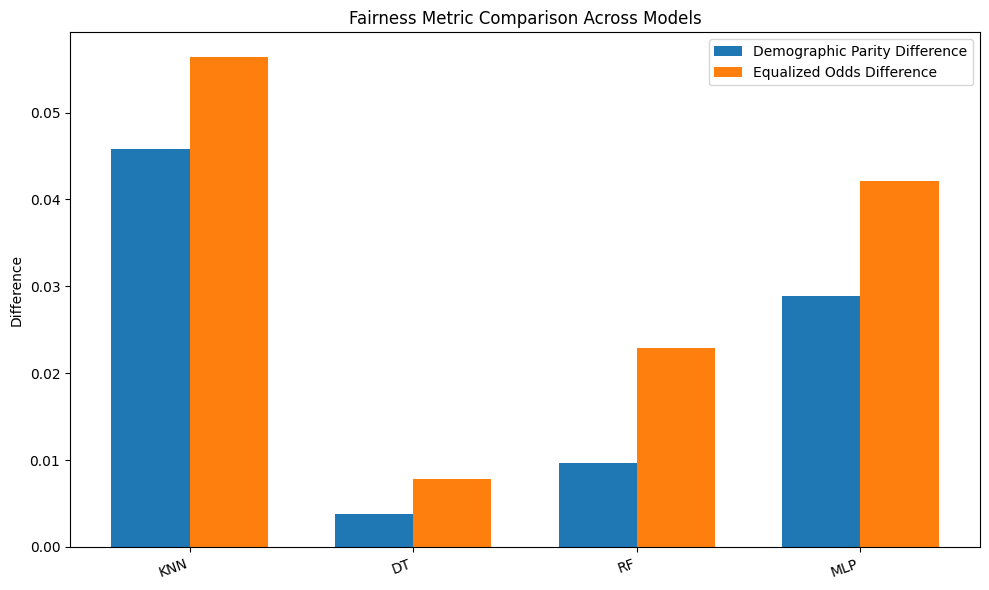

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting DPD and EOD values directly from your dictionary
models = list(fairlearn_results.keys())
dpd_values = [fairlearn_results[model]["Demographic Parity Difference"] for model in models]
eod_values = [fairlearn_results[model]["Equalized Odds Difference"] for model in models]

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

# Plotting
x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(x, dpd_values, width, label='Demographic Parity Difference')
plt.bar(x + width, eod_values, width, label='Equalized Odds Difference')

# Apply shorter labels and rotate them slightly
plt.xticks(x + width / 2, short_labels, rotation=20, ha="right")

plt.ylabel("Difference")
plt.title("Fairness Metric Comparison Across Models")
plt.legend()
plt.tight_layout()
plt.show()

### Interpretation of Fairness Metric Comparison Across Models

The plot compares **Demographic Parity Difference (DPD)** and **Equalized Odds Difference (EOD)** across models:

- **KNN** shows the **largest disparities**, with both DPD (~0.046) and EOD (~0.056) clearly higher than other models.  
- **DT** is the most balanced, with **minimal gaps** in both metrics (DPD ≈ 0.004, EOD ≈ 0.008).  
- **RF** shows small disparities (DPD ≈ 0.010, EOD ≈ 0.023), indicating mild imbalances, especially in error rates.  
- **MLP** lies in between, with moderate DPD (~0.029) and EOD (~0.042).

**Takeaways:**  
- **DT is the fairest model**, showing negligible gender disparities.  
- **RF is also relatively fair**, with small but noticeable gaps.  
- **MLP shows moderate imbalance**, while  
- **KNN is the least fair**, with the highest disparities in both positive prediction rates and error rates.  

---

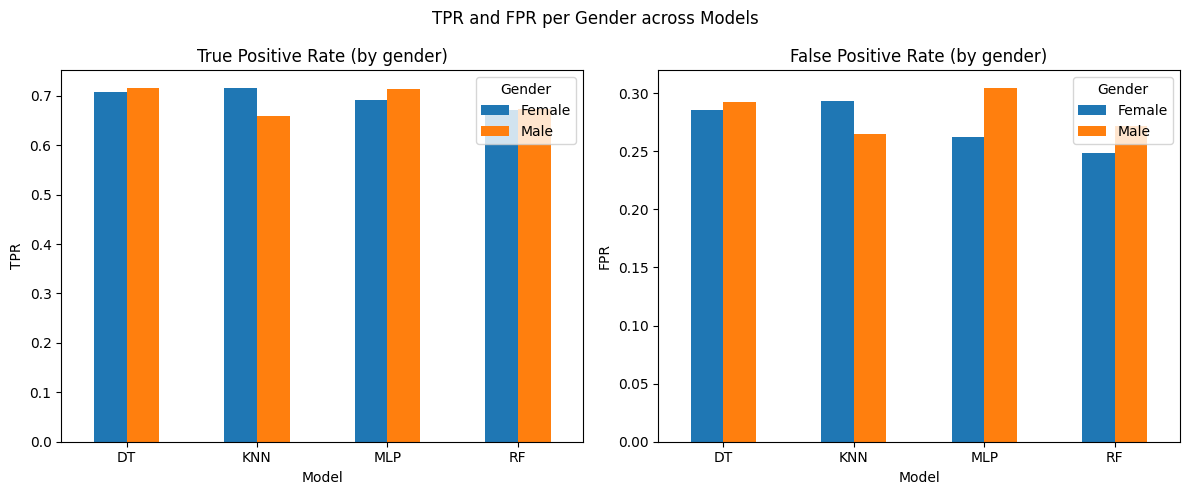

In [29]:
import matplotlib.pyplot as plt

# Collect per-model, per-gender TPR/FPR from your stored MetricFrame tables
rows = []
for model, res in fairlearn_results.items():
    mf = res["MetricFrame"]              
    for g in mf.index:                    
        rows.append({"Model": model, "Gender": g, "TPR": mf.loc[g, "tpr"], "FPR": mf.loc[g, "fpr"]})
df_plot = pd.DataFrame(rows)

# Make gender labels 
df_plot["Gender"] = df_plot["Gender"].map({0: "Female", 1: "Male"}).fillna(df_plot["Gender"])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# TPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="TPR").plot.bar(ax=axes[0], rot=0, legend=True)
axes[0].set_title("True Positive Rate (by gender)")
axes[0].set_ylabel("TPR")

# FPR bar plot
df_plot.pivot(index="Model", columns="Gender", values="FPR").plot.bar(ax=axes[1], rot=0, legend=True)
axes[1].set_title("False Positive Rate (by gender)")
axes[1].set_ylabel("FPR")

plt.suptitle("TPR and FPR per Gender across Models")
plt.tight_layout()
plt.show()

### Interpretation of TPR and FPR Across Models by Gender (with skewed training distribution)

The plots compare **True Positive Rate (TPR)** and **False Positive Rate (FPR)** for females (blue) and males (orange) across the four models.  

- **DT**  
  - TPR: Almost identical (~0.71 for both genders).  
  - FPR: Very close (~0.29).  
  - → Despite training imbalance, DT generalizes well across genders.

- **KNN**  
  - TPR: Higher for females (~0.71 vs. 0.66).  
  - FPR: Also higher for females (~0.29 vs. 0.27).  
  - → Model favors females, consistent with majority representation in training data.  
    Males are more often *missed* (lower recall).

- **MLP**  
  - TPR: Slightly higher for males (~0.71 vs. 0.69).  
  - FPR: Higher for males (~0.30 vs. 0.26).  
  - → Unlike KNN, the MLP compensates somewhat but at the cost of giving males more false alarms.  
    This may reflect overfitting to female-majority patterns and noisier calibration for males.

- **RF**  
  - TPR: Very close for both (~0.67).  
  - FPR: Slightly higher for males (~0.27 vs. 0.25).  
  - → Balanced overall, but again males experience a small disadvantage.

---

### Takeaways
- **DT and RF** are the most balanced despite the skewed training set, suggesting they handle group imbalance robustly.  
- **KNN** tends to favor females (likely due to stronger representation in training), giving them higher recall but also more false positives.  
- **MLP** shifts slightly toward males in recall but penalizes them with more false alarms, indicating calibration issues under data imbalance.  
- The **training imbalance (75% female)** likely explains why females generally achieve more stable and consistent outcomes across models, while males show more variability in error trade-offs.

---

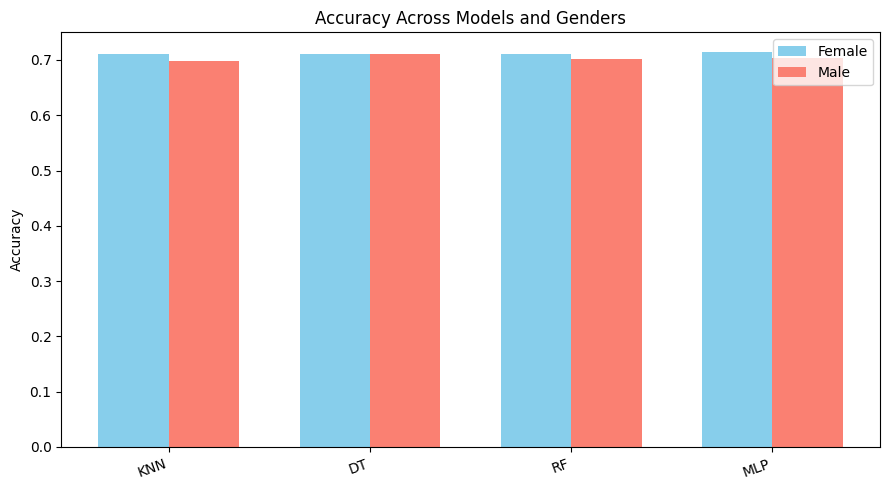

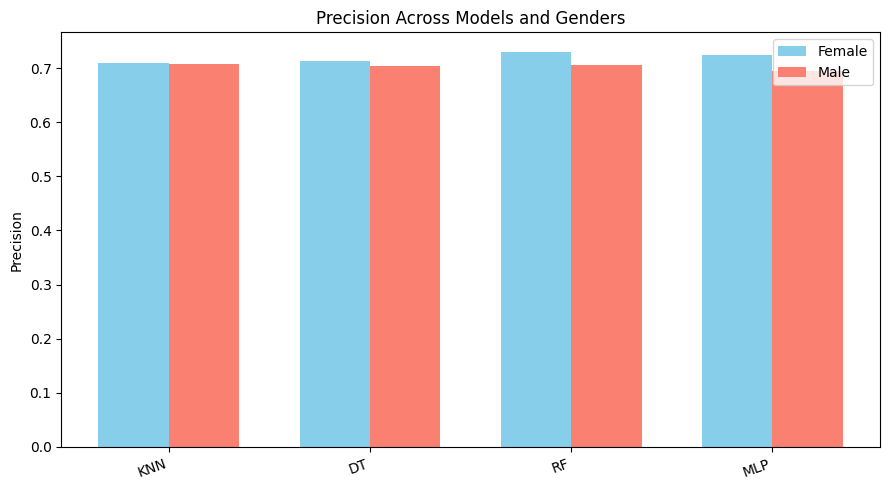

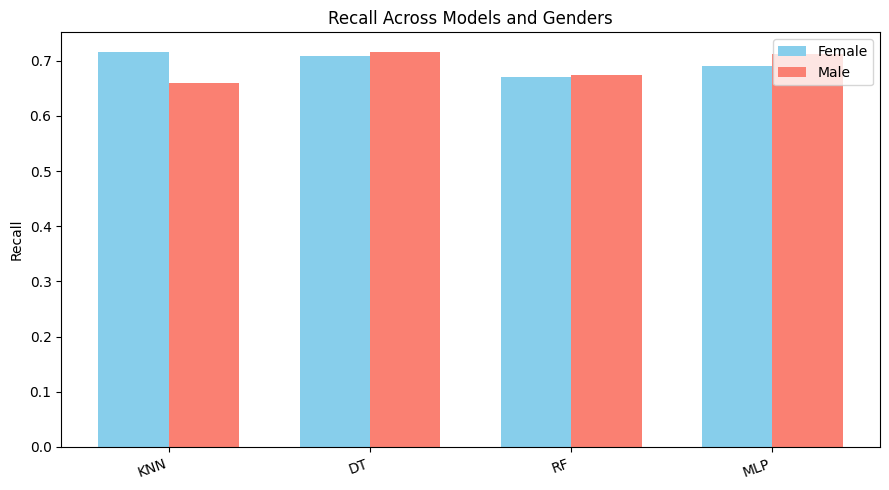

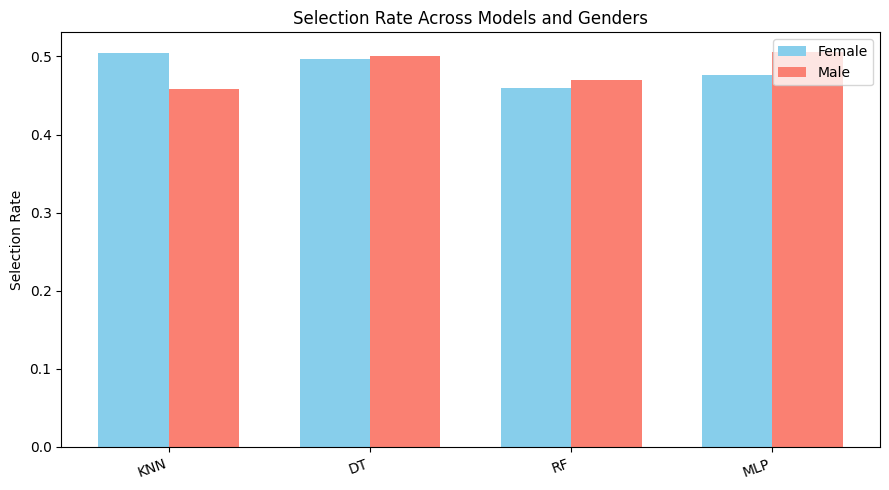

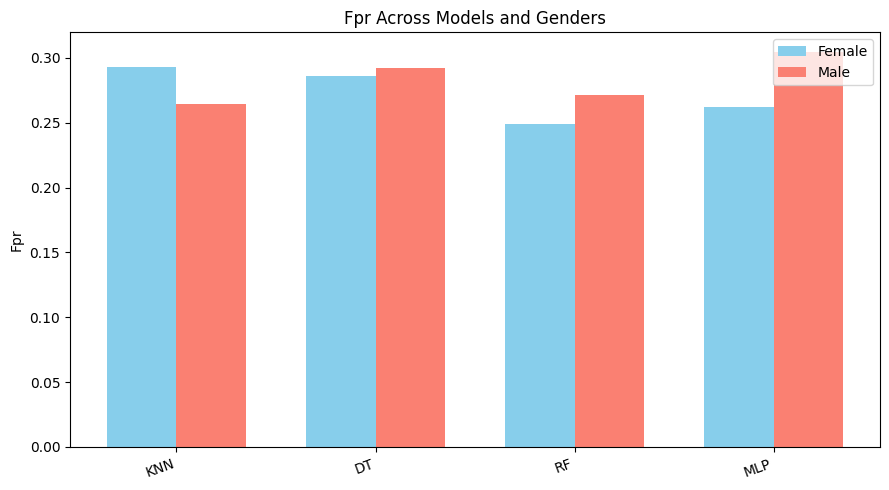

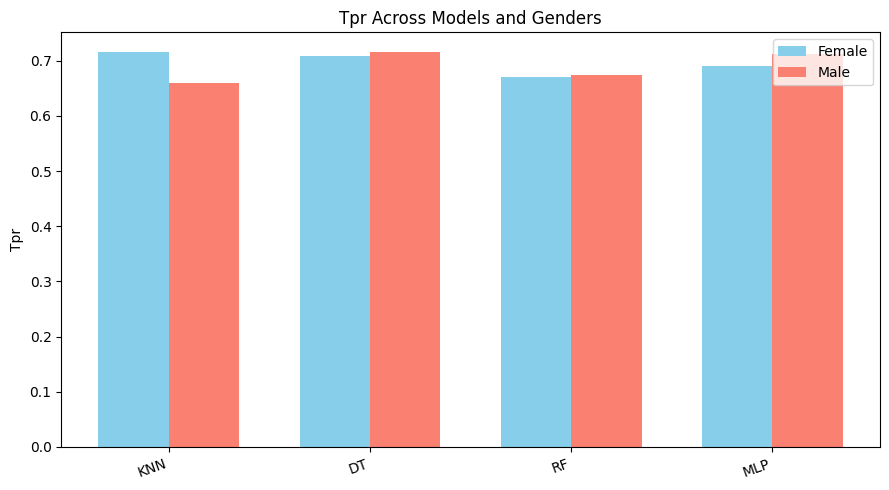

In [30]:
# visualize the comparison
import matplotlib.pyplot as plt
import numpy as np

# Data
models = list(fairlearn_results.keys())

# Shorter labels for better visualization
short_labels = [
    "KNN",
    "DT",
    "RF",
    "MLP",
]

metrics = ['accuracy', 'precision', 'recall', 'selection_rate', 'fpr', 'tpr']
genders = [0, 1]
gender_labels = {0: 'Female', 1: 'Male'}
colors = ['skyblue', 'salmon']

for metric in metrics:
    plt.figure(figsize=(9, 5))
    for idx, gender in enumerate(genders):
        values = [
            fairlearn_results[model]["MetricFrame"].loc[gender][metric]
            for model in models
        ]
        positions = np.arange(len(models)) + idx * 0.35
        plt.bar(positions, values, width=0.35, label=gender_labels[gender], color=colors[idx])
    
    plt.xticks(np.arange(len(models)) + 0.35 / 2, short_labels, rotation=20, ha='right')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.title(f"{metric.replace('_', ' ').title()} Across Models and Genders")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Interpretation of Performance and Fairness Plots

With a training set of **75% females and 25% males**, the models show only small gender gaps overall.  

- **Accuracy**: Very similar across genders in all models (<2% gap).  
- **Precision**: Slightly higher for females in RF and MLP → males get more false positives.  
- **Recall / TPR**:  
  - KNN favors females (~5% higher).  
  - DT slightly favors males.  
  - RF and MLP are nearly balanced.  
- **Selection rate**: KNN predicts more positives for females, while DT and MLP slightly favor males; RF is balanced.  
- **FPR**: Higher for females in KNN, higher for males in DT, RF, and MLP.  

**Summary**:  
- **KNN** shows the strongest gender disparity (favors females in recall but penalizes them with more false positives).  
- **DT** is balanced with a small male advantage.  
- **RF and MLP** are the most stable, with minimal gender gaps.  

---